In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Download the required libraries
from __future__ import print_function, division

import numpy as np
import torch
import torchvision
import os
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.onnx
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

%matplotlib inline

plt.ion()   # interactive moden

In [3]:
#get address
data_dir="/content/drive/MyDrive/datasets/"

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):

    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [5]:
riterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

**Transer Learning**

pretrained model Renset18 train datasets

In [6]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['arial', 'calibri', 'times new roman', 'verdana']
The datasest have:  {'train': 414, 'test': 134}  images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


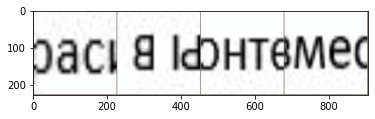

calibri arial calibri calibri


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Функция обучения модели

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Параметры для обучения модели

In [11]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Обучение модели

In [12]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2322 Acc: 0.4614
test Loss: 1.8186 Acc: 0.4328

Epoch 1/24
----------
train Loss: 0.9967 Acc: 0.6087
test Loss: 1.0161 Acc: 0.6493

Epoch 2/24
----------
train Loss: 0.8028 Acc: 0.6981
test Loss: 0.7933 Acc: 0.7537

Epoch 3/24
----------
train Loss: 0.8083 Acc: 0.7029
test Loss: 0.9343 Acc: 0.7463

Epoch 4/24
----------
train Loss: 0.5574 Acc: 0.8092
test Loss: 0.8194 Acc: 0.7537

Epoch 5/24
----------
train Loss: 0.6350 Acc: 0.7367
test Loss: 0.5788 Acc: 0.8134

Epoch 6/24
----------
train Loss: 0.3836 Acc: 0.8430
test Loss: 0.4231 Acc: 0.8806

Epoch 7/24
----------
train Loss: 0.5199 Acc: 0.8333
test Loss: 0.5267 Acc: 0.8731

Epoch 8/24
----------
train Loss: 0.3688 Acc: 0.8551
test Loss: 0.5055 Acc: 0.8806

Epoch 9/24
----------
train Loss: 0.3519 Acc: 0.8841
test Loss: 0.4987 Acc: 0.8657

Epoch 10/24
----------
train Loss: 0.2804 Acc: 0.9082
test Loss: 0.4582 Acc: 0.8955

Epoch 11/24
----------
train Loss: 0.2686 Acc: 0.9082
test Loss: 0.5016 Acc: 0.8582

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.1195,  0.0267, -0.4185,  4.2052])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.1282,  1.5575, -3.8555,  5.8835])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 3.2405, -0.9354,  4.2942, -7.3175])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 4.8699,  1.2634, -2.3586, -2.8876])


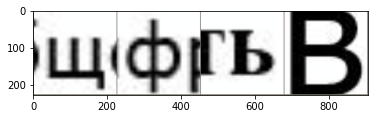

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.8810,  6.2728, -6.0570, -2.2579])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.1611,  5.0349, -4.7757, -2.2866])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.6137,  4.7358,  0.3591, -5.1916])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.8579,  2.3839, -4.8419,  3.0284])


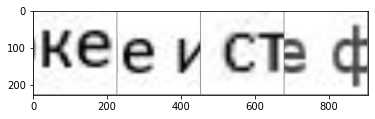

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.1067, -0.4154,  7.1753, -3.3235])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.5662, -2.9884, -1.6793,  7.1559])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 4.6209,  1.5818, -3.5551, -2.0473])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.5712,  6.8152, -2.3177, -4.2869])


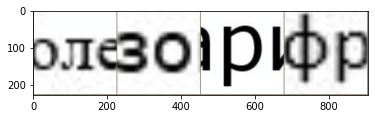

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 6.5763,  1.6064, -2.0675, -5.8133])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.2767, -2.5061, -3.7279, 10.3322])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.8040,  2.5928, -3.0825, -6.4622])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.6274,  5.2069, -6.8503, -1.8462])


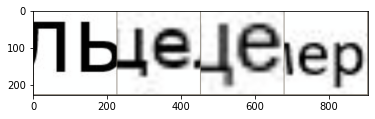

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.0734, -0.0855, -0.7867, -5.7820])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.2523,  3.7575, -8.6015,  4.0468])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.0389,  3.8627, -2.1221,  0.9113])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.9704,  0.8785,  2.2022, -3.5670])


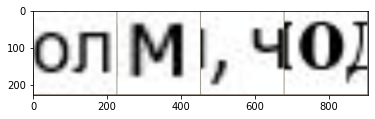

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.9313,  0.3394, -1.0304, -2.4097])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.2784,  4.0829, -1.4389, -3.6578])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.3342,  2.6452, -2.4627, -1.4925])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.8475, -1.0655, -0.9506, -4.5621])


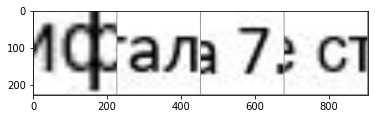

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.8608, -3.1417,  7.2407, -4.0818])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.3612,  0.5460,  5.9526, -6.0599])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.0932,  4.2050,  0.1170, -5.2797])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.0808, -0.4660,  6.5891, -4.3745])


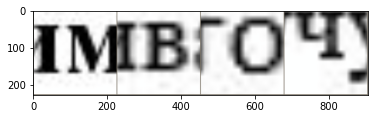

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.9600, -0.5746, -0.2251, -3.0020])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.2066,  0.7432,  0.3703, -6.3757])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.8474,  4.4824, -5.6323, -0.6365])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.0481,  2.6197, -6.5617,  5.8854])


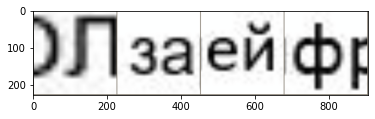

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ -0.1693,   3.7797,   7.6497, -10.1586])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.4129,  2.7456,  0.2779, -4.8700])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.5268,  3.8259, -7.2267,  3.9596])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.2228,  2.9120, -5.0827,  1.8370])


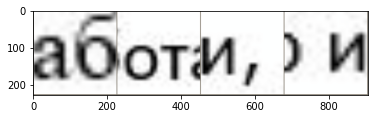

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.5348,  4.7121, -0.8816, -5.5237])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.2193, -1.1634,  0.7605, -3.1056])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.3238, -0.3579, 10.6636, -7.2804])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.0545,  1.1128, -6.8394,  4.4501])


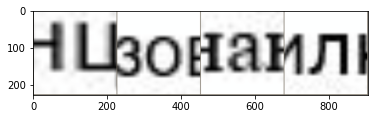

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.3763,  0.1182, -0.2164, -5.6752])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.0920,  3.4644, -0.9255, -5.2800])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.9319,  6.7083, -0.0770, -4.3032])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2583,  5.3873, -0.6929, -6.2712])


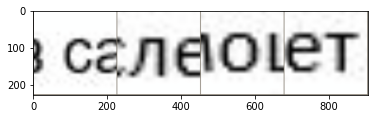

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.9019, -0.9462,  0.8690, -1.3769])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.1605,  2.5319, -4.9146, -2.4843])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.6809,  4.4719, -1.7767, -4.3596])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.9611,  6.3327,  1.2213, -9.2403])


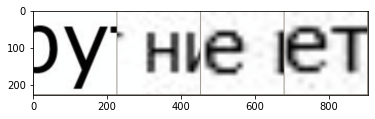

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 7.1565,  2.4092, -1.2879, -8.1652])
Predict class - calibri, real class - arial, probability (arial,calibri) - tensor([ 2.6988,  2.8388, -4.6410, -1.0052])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.4014,  4.7440, -0.9436, -5.4115])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3610,  6.1484, -5.1150, -3.5673])


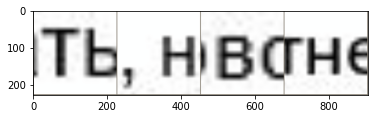

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-5.0662,  0.7225, -2.4252,  5.9877])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.3232,  1.1847, -0.7067, -5.2983])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.3945,  1.8109,  4.5391, -4.5058])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.3793, -2.0484,  9.1735, -4.6855])


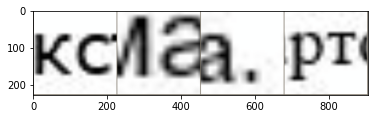

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.8966, -2.9718, -4.6470,  6.4836])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.1239, -2.4626, -3.4705,  5.2381])
Predict class - calibri, real class - arial, probability (arial,calibri) - tensor([ 0.2994,  2.3254, -4.9306,  1.6837])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.1455,  2.1850, -6.0449,  4.2183])


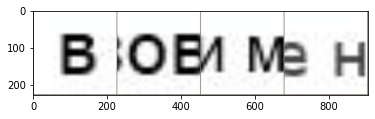

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.3586, -2.4562, -2.0051,  7.2037])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 0.4456,  0.8805, -0.5415, -0.8427])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.2466,  5.0065,  2.0700, -6.7035])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.7572,  1.7202, -5.7169,  2.0216])


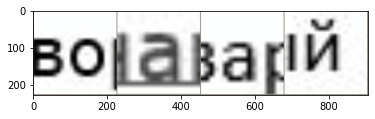

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.9405, -2.6786, -1.8585,  9.1985])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.7971,  1.6601, -6.5466,  5.3977])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.2793,  1.8569,  6.0511, -5.0947])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9603,  0.2473, -5.2538,  5.9113])


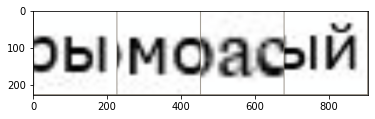

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-4.0729, -0.2062,  8.0124, -3.6032])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.6764,  4.1651, -1.4069, -4.4853])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.2508,  0.8367, -7.8173,  6.4743])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.4168,  2.5861, -2.7354, -0.9847])


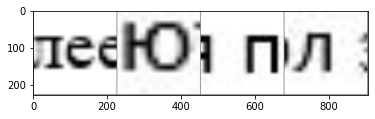

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.9574,  4.2997, -3.2324, -2.5756])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.1590, -1.4723,  5.8891, -3.6029])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.0429,  1.8228,  4.2337, -7.1274])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.4295,  0.9181,  5.8589, -4.5330])


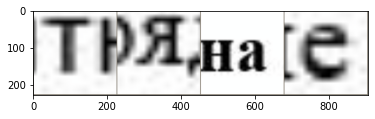

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.0294,  4.6701,  0.3598, -4.4916])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-5.0403, -3.5235,  7.9764, -1.4513])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.1848,  5.1753, -0.3696, -6.0163])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.1824,  3.0930, -7.9704,  8.4809])


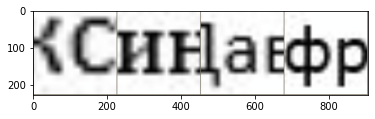

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ -0.0609,   4.6088,   7.0343, -10.7019])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.7429, -1.5040, -4.9690,  7.9415])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.4319,  1.3251, -3.3289,  4.9027])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.0042, -2.4576,  0.5727,  5.9261])


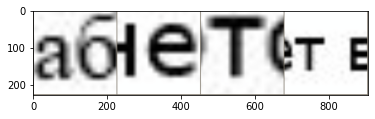

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.1442,  0.1648, -1.3411, -3.5292])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.2629, -0.3023, -5.7878,  6.5223])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.5411,  3.9719,  2.3953, -5.1380])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.0340,  3.1240, -0.7341, -3.7526])


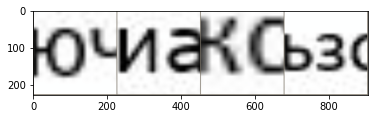

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.9139,  6.3985,  0.0191, -8.5503])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.3255,  4.7508, -0.4142, -1.7368])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.5247, -0.5157,  5.5406, -2.6382])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.9802,  3.5550,  0.4275, -8.5326])


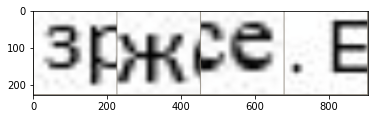

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-5.0826, -0.8970, -3.0987,  9.1433])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.7188,  4.7058, -9.1482,  8.1664])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 0.9026,  1.5443, -1.2151, -1.3202])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([-1.4522,  2.6127, -2.0574,  2.0778])


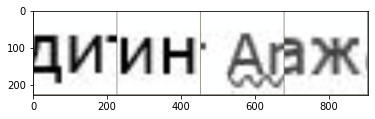

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.3536,  6.2940,  0.2806, -6.2527])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.5869, -2.8213,  9.4042, -4.5108])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.4597, -2.6004, -3.8595,  6.8278])
Predict class - calibri, real class - arial, probability (arial,calibri) - tensor([ 2.9159,  3.5084, -2.7661, -5.2173])


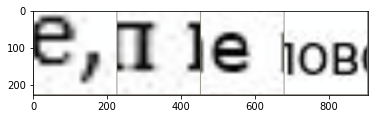

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.2633, -1.0580, -4.8879,  5.3764])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.5582,  0.6205, -4.7038,  2.2581])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.3162,  2.9562, -5.8776,  2.5461])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.3849,  1.9591, -5.2218,  2.7956])


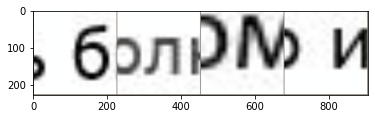

Predict class - calibri, real class - arial, probability (arial,calibri) - tensor([ 1.1628,  1.9997, -2.2148, -1.0512])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.8874,  0.8188,  0.6268, -5.7810])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 1.6189,  0.5902,  0.5127, -2.9231])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 3.9931, -1.2329,  4.2752, -6.6279])


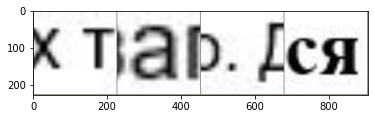

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.7484,  4.6556, -5.7311, -1.3171])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.8511, -1.1136,  7.8076, -4.2232])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9299,  1.0713, -5.2576,  3.8410])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.6763, -1.9465,  6.7414, -3.7160])


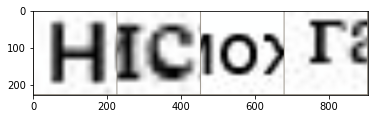

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.8425,  4.4190, -1.7132, -4.7519])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.4242, -1.0524, -4.8165,  5.4464])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.1914, -1.8878, -3.3274,  5.9006])
Predict class - times new roman, real class - calibri, probability (arial,calibri) - tensor([-1.0529, -0.8201,  1.8352, -1.0831])


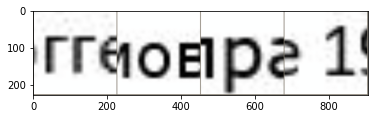

Predict class - arial, real class - times new roman, probability (arial,calibri) - tensor([ 3.8715, -0.0601,  1.4962, -5.6218])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.4781, -3.1755, -3.2136,  9.9824])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.2942, -2.5123,  6.7628, -4.9417])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.4175, -3.1303, -2.5074,  8.5539])


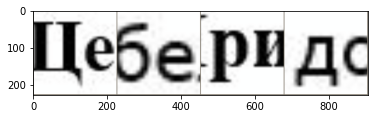

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.7618, -1.9234, -0.1793, -2.6658])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.5359,  2.8920, -7.0301, -2.7901])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.9398,  4.8401, -0.3819, -4.1875])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.5409,  4.2242, -2.3039, -2.9014])


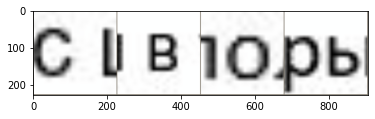

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.4579,  1.2705, -6.7169,  7.4443])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.6191,  7.0970, -4.3894, -1.1418])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.9017,  0.3415, -2.5950,  7.0902])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.8882,  2.0623, -4.4780,  5.5799])


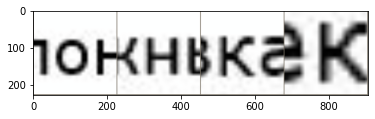

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.5934,  0.8003,  6.3991, -3.5270])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.8524,  6.8818, -2.1735, -5.9608])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 3.0803,  0.2983, -1.2018, -2.3871])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.2141, -1.1757,  8.7115, -3.8456])


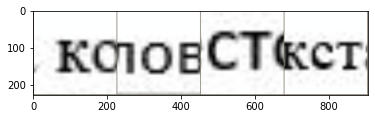

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.9154,  4.1931, -2.5474, -5.5816])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.0211, -1.7694, -2.9326,  7.1797])


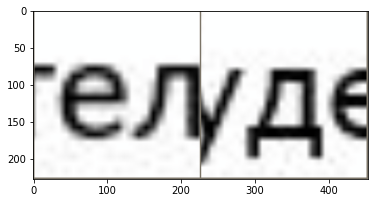

Accuracy of the network on the 134 test images: 89 %


In [13]:
# Visualization results of analysis test data
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

In [14]:
'''# Export model to onnx format
PATH =os.path.join(dir, "my_resnet18.onnx")
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(model_ft, dummy_input, PATH)'''

'# Export model to onnx format\nPATH =os.path.join(dir, "my_resnet18.onnx")\ndummy_input = Variable(torch.randn(1, 3, 224, 224))\ntorch.onnx.export(model_ft, dummy_input, PATH)'

PTH

In [15]:
#Save and load model
PATH =os.path.join('/content/', "my_model.pth")
torch.save(net.state_dict(), PATH)
#load
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Pickle

In [16]:
 # Save a dictionary into a pickle file.
import pickle
pickle.dump(model_ft, open("model.pcl", "wb"))

In [17]:
model = pickle.load(open("model.pcl", "rb"))

In [18]:
#model

Input for predict

In [19]:
#!rm -R .ipynb_checkpoints
#!ls -a  

In [20]:
#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):
    
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['valid']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['valid']}

    return dataloaders['valid']

In [21]:
data_dir = '/content/drive/MyDrive/datasets'
dataloaders_test = get_dataset(data_dir, data_transforms)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
correct = 0 
total = 0 

for data in dataloaders_test:
        
        images, labels = data
        print(labels)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(torch.max(outputs.data, 1))
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, {2}'.format(printclass[0],printclass[1], printdata[2]))
            
        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        #imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

print('Accuracy of the network: {}'.format(correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 1, 1, 3])
Predict class - calibri, real class - calibri, tensor([-0.4658,  4.8028, -0.8016, -4.6261], grad_fn=<UnbindBackward0>)
Predict class - arial, real class - calibri, tensor([ 4.5498,  1.5089,  1.9355, -7.4751], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - calibri, tensor([-1.4851,  4.0048,  1.6451, -5.1234], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, tensor([-0.3800, -1.8555, -6.4176,  7.2371], grad_fn=<UnbindBackward0>)
tensor([1, 2, 2, 1])
Predict class - calibri, real class - calibri, tensor([-0.2109,  5.4113, -1.5767, -4.4887], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - times new roman, tensor([-1.8336,  3.1932,  2.9442, -5.3009], grad_fn=<UnbindBackward0>)
Predict class - times new roman, real class - times new roman, tensor([-0.1332, -1.5716,  4.8143, -0.5575], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - calibri, tensor([-0.8902,  0.7998, -1.6152,  1.2951], grad_fn=<Un

Preprocess img

In [23]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [34]:
#preprocess input image
def preprocess_input(image_pth):

  try:
    test_img = Image.open(image_pth).convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
  except:
    test_img = image_pth.convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)

  return input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [25]:
#0-arial, 1-calibri, 2-tnr, 3-verdana
def pred_font(output):
  if (output == output.max().item()).nonzero()[0][1] == torch.tensor(0):
    return 'arial'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(1):
    return 'calibri'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(2):
    return 'times new roman'
  else:
    return 'verdana'

In [26]:
%%timeit
image_pth = '/content/drive/MyDrive/datasets/valid/verdana/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))          

10 loops, best of 5: 99 ms per loop


In [27]:
image_pth = '/content/drive/MyDrive/datasets/valid/verdana/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))

'verdana'

In [28]:
image_pth = '/content/drive/MyDrive/datasets/valid/arial/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'

In [29]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))       

'times new roman'

In [30]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))      

'times new roman'

In [35]:
image_pth = '/content/test10.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'calibri'

Создание датасета ч\з EasyOCR из изображения

In [36]:
!pip install opencv-python-headless==4.1.2.30
!pip install easyocr
!pip install pymorphy2

     |████████████████████████████████| 21.8 MB 1.5 MB/s 
     |████████████████████████████████| 70.8 MB 17 kB/s 
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 6.9 MB/s 


In [37]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw
import easyocr
from google.colab.patches import cv2_imshow
import re
import pymorphy2
from tqdm import tqdm

morph = pymorphy2.MorphAnalyzer()

In [38]:
def easy_OCR(image, lang):
  
  #image's data
  reader = easyocr.Reader([lang]) 
  result = reader.readtext(image)#, width_ths=0.7, mag_ratio=3, canvas_size=4000)

  return result

**До: Cоздать папку под dataset**

In [39]:
!mkdir dataset

In [40]:
#func for get dataset

def get_train_data(data, image, font='None', last=0):

    labels = pd.DataFrame()
    expansion = 5

    for idx in tqdm(range(len(data))):

            top = data[idx][0][0][1]
            left = data[idx][0][0][0]
            right = data[idx][0][2][0]
            bottom = data[idx][0][2][1]
            
            img = image.crop((left, top, right, bottom))
            img = img.convert("L")
            img.save('/content/dataset/'+str(idx+last)+'.jpg')
            
            labels = labels.append({'filename': str(idx+last)+".jpg",
                                    'file': np.matrix(img),
                                    'img': img,
                                    'font': font, 
                                    'word': data[idx][1]},
                                   ignore_index=True)

    return labels

In [41]:
#check image for font
from collections import Counter

def fonts_image(labels):

  font = []

  for image in tqdm(labels):

      input_img = preprocess_input(image)
      font.append(pred_font(model(input_img)))

  return Counter(font)

In [42]:
#realize get dataset
image = '/content/text3.png'
result = easy_OCR(image, lang="ru")
labels = get_train_data(result, Image.open(image))
fonts_image(labels['img'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

100%|██████████| 34/34 [00:03<00:00,  9.35it/s]


Counter({'arial': 30, 'calibri': 4})

In [43]:
#realize get dataset
image = '/content/text_calibri.png'
result = easy_OCR(image, lang="ru")
labels = get_train_data(result, Image.open(image))
fonts_image(labels['img'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 42/42 [00:04<00:00,  9.94it/s]


Counter({'calibri': 42})

In [44]:
#realize get dataset
image = '/content/text_tnr.png'
result = easy_OCR(image, lang="ru")
labels = get_train_data(result, Image.open(image))
fonts_image(labels['img'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:03<00:00,  9.79it/s]


Counter({'times new roman': 39})

In [45]:
%%timeit
#realize get dataset
image = '/content/text_tnr.png'
result = easy_OCR(image, lang="ru")
labels = get_train_data(result, Image.open(image))
fonts_image(labels['img'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:04<00:00,  9.74it/s]
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:04<00:00,  9.74it/s]
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:04<00:00,  9.70it/s]
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:03<00:00,  9.78it/s]
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:03<00:00,  9.78it/s]
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 39/39 [00:04<00:00,  9.61it/s]

1 loop, best of 5: 2min 26s per loop


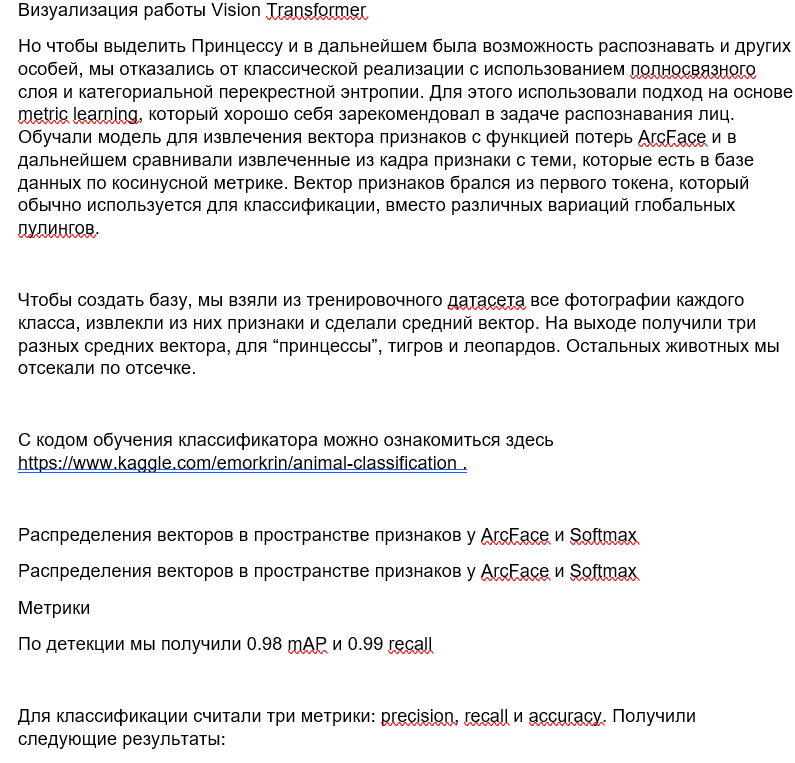

In [46]:
Image.open('/content/text3.png')

In [47]:
#вырезаем однотонные линии по горизонтали
def crop_img(image_pth):

  COUNT_IMG = 30 #подобрать параметр ??
  cropped_image_array = []
  image = Image.open(image_pth)

  len_image_horizontal = np.array(image).shape[0]/COUNT_IMG
  len_image_vertical = np.array(Image.open(image_pth)).shape[1]/COUNT_IMG
  
  for elem_horizontal in range(COUNT_IMG):
    for elem_vertical in range(COUNT_IMG):
      left = (elem_horizontal-1) * len_image_horizontal
      top = (elem_vertical-1) * len_image_vertical
      right = elem_horizontal * len_image_horizontal
      bottom = elem_vertical * len_image_vertical

      cropped_image = image.crop((left, top, right, bottom))
      cropped_image_array.append(cropped_image)

  return cropped_image_array

In [48]:
image = Image.open('/content/text3.png')

#удаление однотонных строк по горизонтали
def clean_img(image):

  elem2crop = []
  new_tensor = []

  elem2crop.extend([elem for elem in tqdm(range(len(np.array(image)))) if np.array(image)[elem].min() == np.array(image)[elem].max()])
  
  new_tensor.extend([np.array(image)[elem] for elem in tqdm(range(len(np.array(image)))) if elem not in elem2crop])

  return Image.fromarray(np.array(new_tensor))

In [49]:
clean_img(image).save('/content/text4.png')

100%|██████████| 763/763 [00:00<00:00, 1372.12it/s]


In [50]:
PTH = '/content/text3.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

100%|██████████| 900/900 [01:29<00:00, 10.09it/s]


Counter({'arial': 306, 'calibri': 161, 'times new roman': 39, 'verdana': 394})

In [52]:
%%timeit
PTH = '/content/text3.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

100%|██████████| 900/900 [01:26<00:00, 10.41it/s]

1 loop, best of 5: 1min 26s per loop


In [53]:
PTH = '/content/text4.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

100%|██████████| 900/900 [01:27<00:00, 10.31it/s]


Counter({'arial': 142, 'calibri': 161, 'times new roman': 43, 'verdana': 554})

In [54]:
%%timeit
PTH = '/content/text4.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

100%|██████████| 900/900 [01:26<00:00, 10.37it/s]

1 loop, best of 5: 1min 26s per loop


In [55]:
PTH = '/content/text_calibri.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

100%|██████████| 900/900 [02:15<00:00,  6.65it/s]


Counter({'arial': 2, 'calibri': 496, 'times new roman': 35, 'verdana': 367})

In [ ]:
PTH = '/content/text_tnr.png'

cropped_image_array = crop_img(image_pth=PTH)

fonts_image(cropped_image_array)

 72%|███████▏  | 647/900 [02:21<01:07,  3.77it/s]

Подача текста полностью

In [63]:
#весь текст #верно - arial
image_pth = '/content/text3.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'times new roman'

In [ ]:
%%timeit
#весь текст #верно - arial
image_pth = '/content/text3.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

In [64]:
#текст без однотонных линий #верно - arial
image_pth = '/content/text4.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'

In [66]:
#текст подобно EasyOCR #верно - arial
image_pth = '/content/text5.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'calibri'

In [61]:
#весь текст #верно - сalibri
image_pth = '/content/text_calibri.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'

In [62]:
#весь текст #верно - tnr
image_pth = '/content/text_tnr.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'